In [15]:
import numpy as np
import torch
import pandas as pd
from comet import download_model, load_from_checkpoint
from typing import List
import json
from transformers import AutoTokenizer
from matplotlib import pyplot as plt
import numpy

In [12]:
cometqe_dir = "./cometqemodel"
cometqe_model = "wmt20-comet-qe-da"
cometmodel = "wmt20-comet-da"
batch_size = 64
def load_cands(fname):
    data = []
    with open(fname, 'r') as file:
        while True:
            line = file.readline()
            #print(line)
            # if line is empty
            # end of file is reached
            if not line or len(line)<3:
                break

            data.append(json.loads(line))
    return data

def process_cands(cand_data):
    refs = []
    hyps = []
    srcs = []
    clen = len(cand_data['scores'])
    # return refs, hyps, srcs
    return [cand_data['ref']]*clen, cand_data['cands'], [cand_data['inp']]*clen
        

def get_average_score(cand_data):
    scoresum = 0
    scoretot = 0
    for c in cand_data:
        scoresum+=sum(c['rescores'])
        scoretot+=len(c['rescores'])
    return scoresum/scoretot

def amax_score(cand_data):
    scoresum = 0
    scoretot = 0
    for c in cand_data:
        scoresum+=max(c['rescores'])
        scoretot+=1
    return scoresum/scoretot

get_average_score(lat_cands[:100])

1.0309393282155523

In [16]:
# figure out average token length
lentok = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt", src_lang="de_DE")
beam_cands = load_cands("./candoutputs/beam40en_degoodrescored.jsonl")
lat_cands = load_cands("./candoutputs/latde100rescored.jsonl")

(array([11., 14., 15., 17., 12., 10., 10.,  5.,  3.,  3.]),
 array([ 7. , 14.6, 22.2, 29.8, 37.4, 45. , 52.6, 60.2, 67.8, 75.4, 83. ]),
 <BarContainer object of 10 artists>)

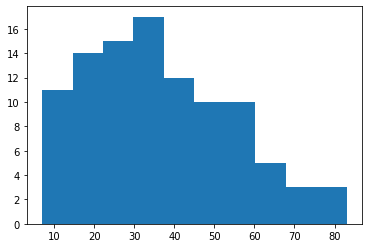

In [20]:
#inputs = lentok(beam_cands[0]['ref'])
def get_len_distr(cands):
    maxlen = 0
    totlen = 0
    vals = []
    for c in cands:
        try:
            tmp = len(lentok(c['ref'])['input_ids'])
        except:
            print("issue")
            tmp = maxlen
        maxlen = max(maxlen, tmp)
        totlen+=tmp
        vals.append(tmp)
    return vals
        
len_dist = get_len_distr(lat_cands[:100])
plt.hist(len_dist)

In [5]:
def debug_cand(ind):

    print(cand_data[ind]['ref'])
    for c in cand_data[ind]['cands']:
        print(c)
        
def find_common(c1, c2list):
    for c in c2list:
        if c['ref']==c1['ref']:
            return c
        
def get_cometqe_scores(hyps, srcs):
    cometqe_input = [{"src": src, "mt": mt} for src, mt in zip(srcs, hyps)]
    # sentence-level and corpus-level COMET
    outputs = model.predict(
        cometqe_input, batch_size=40, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

def get_comet_scores(hyps, srcs, refs):
    cometqe_input = [{"src": src, "mt": mt, "ref":ref} for src, mt, ref in zip(srcs, hyps, refs)]
    # sentence-level and corpus-level COMET
    outputs = comet.predict(
        cometqe_input, batch_size=40, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

def test_cometqe(hyp, src):
    cqe_input = [{'src':src, 'mt':hyp}]
    outputs = model.predict(
        cqe_input, batch_size=1, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

In [4]:
#print(beam_cands[0]['cands'][0])
def comp_debug_cand(ind, k):
    if len(lat_cands[ind]['cands'])==0:
        return
    print("INPUT")
    print(lat_cands[ind]['inp'])
    print("REF")
    print(lat_cands[ind]['ref'])
    print("LATTICE")
    for i in range(0, k):
        try:
            print(lat_cands[ind]['scores'][i])
            print(lat_cands[ind]['cands'][i])
        except:
            #print("NONE")
            ""
    print("BEAM")
    common = find_common(lat_cands[ind], beam_cands)
    #print(common)
    for i in range(0, k):
        print(common['scores'][i])
        print(common['cands'][i])
    print("BEAM")
    print(get_comet_scores([common['cands'][0]], [lat_cands[ind]['inp']], [lat_cands[ind]['ref']]))
    print("LATTICE")
    print(get_comet_scores([lat_cands[ind]['cands'][0]], [lat_cands[ind]['inp']], [lat_cands[ind]['ref']]))

for i in range(1, 20):
    comp_debug_cand(i, 5)

NameError: name 'lat_cands' is not defined

In [7]:
comet_path = download_model(cometmodel, "./cometmodel")
comet = load_from_checkpoint(comet_path)

wmt20-comet-da is already in cache.
Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Encoder model frozen.


In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

device = "cuda:2" if torch.cuda.is_available() else "cpu"


tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-one-to-many-mmt", src_lang="en_XX", tgt_lang="de_DE")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-one-to-many-mmt")
model.to(device)
print("")

In [46]:
del tokenizer
del model

In [42]:
def get_mbart_nll(cand, ind, tok, mod):

    inp = cand['inp']
    out = cand['cands'][ind]
    

    inputs = tokenizer(inp, return_tensors="pt").to(device)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(out, return_tensors="pt").to(device)


    # forward pass
    output = model(**inputs, labels=labels.input_ids)
    #print(type(labels))
    #print(labels.attention_mask)
    return output.loss

def test_cand(cand, ind):
    print(get_mbart_nll(cand, ind))
    print(cand['scores'][ind])
    
def rescore_cands(c_list):
    device = "cuda:2" if torch.cuda.is_available() else "cpu"
    mname = "facebook/mbart-large-50-one-to-many-mmt"
    src_l = "en_XX"
    tgt_l = "de_DE"
    tok = tokenizer
    mod = model
    # tok = AutoTokenizer.from_pretrained(mname, src_lang=src_l, tgt_lang=tgt_l)
    # mod = AutoModelForSeq2SeqLM.from_pretrained(mname)
    # mod.to(device)
    i = 0
    for c in c_list:
        c['oldsco'] = c['scores']
        c['scores'] = []
        for can in range(0, len(c['cands'])):
            c['scores'].append(float(get_mbart_nll(c, can, tok, mod)))
        c['sco_ranks'] = list(numpy.argsort(c['scores']))
        print(i)
        i+=1
    # del tok
    # del mod
    return c_list
        

In [43]:
resc = rescore_cands(lat_cands)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


KeyboardInterrupt: 

In [ ]:
resc

In [44]:
lat_cands[0]['scores'][0]

In [57]:
type(model)

transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration